# But first, import!

In [1]:
# our core libraries
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import mean_squared_error

from sklearn.pipeline import make_pipeline

from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor

# Next, load the data..

To `netmaps_df` we load "netmaps" which are subject-specific “parcellated connectomes” – for each subject, a nodes x nodes network matrix. See more [here](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP1200-DenseConnectome+PTN+Appendix-July2017.pdf).

To `behavioral_df` we load the data keys. See more [here](https://wiki.humanconnectome.org/display/PublicData/HCP-YA+Data+Dictionary-+Updated+for+the+1200+Subject+Release). 

In [2]:
N = 100
netmaps_df = pd.read_csv('data/connectivityml/HCP_PTN1200/netmats/3T_HCP1200_MSMAll_d'+str(N)+'_ts2/netmats2.txt', delim_whitespace=True,header=None)
print("Network-matrices data shape:", netmaps_df.shape)
netmaps_df.head()

Network-matrices data shape: (1003, 10000)


,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0,0.616760,9.5727,-5.4959,0.34639,3.0090,3.2134,1.1298,1.58890,-2.33410,...,1.185400,1.55440,1.369600,1.3055,2.8770,1.66720,0.14911,3.0171,0.26007,0
1,0,-0.296640,17.3170,-9.0467,-0.28723,1.3473,1.0459,1.7133,0.49141,-0.29712,...,0.038296,0.99805,0.618580,1.6566,2.5237,-0.40272,-0.38607,3.0958,1.29190,0
2,0,1.648600,6.6189,-8.8877,1.43370,1.0060,2.1167,2.4575,-0.11689,1.96460,...,-0.068334,0.83626,-0.004783,2.5012,8.2278,0.83097,-1.69360,2.8515,-2.08240,0
3,0,-0.902750,7.7215,-8.3907,3.31440,2.9395,3.4270,6.7093,1.36210,-2.66980,...,0.605570,0.98066,-0.791140,3.7111,4.3410,-0.29930,0.46776,2.4837,0.59513,0
4,0,-0.088768,9.4979,-10.4120,1.06460,4.3362,1.7206,4.5520,3.19110,-3.30900,...,1.709600,0.99331,0.326620,2.5242,4.2467,0.51453,-0.40380,1.2692,1.19840,0


In [3]:
behavioral_df = pd.read_csv('data/connectivityml/unrestricted_pkalra_7_26_2021_17_39_25.csv')
print("Behaviora data shape:", behavioral_df.shape)
behavioral_df.head()

Behaviora data shape: (1206, 582)


,Subject,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
0,100004,S900,Q06,M,22-25,False,0,0,0,0.0,...,5.2,101.12,86.45,2.0,45.9,107.17,105.31,1.80,0.0,1.80
1,100206,S900,Q11,M,26-30,True,1,1,4,100.0,...,6.0,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84
2,100307,Q1,Q01,F,26-30,True,1,1,4,100.0,...,3.6,101.12,86.45,0.0,38.6,71.69,71.76,1.76,0.0,1.76
3,100408,Q3,Q03,M,31-35,True,1,1,4,100.0,...,2.0,108.79,98.04,2.0,52.6,114.01,113.59,1.76,2.0,1.68
4,100610,S900,Q08,M,26-30,True,2,1,4,100.0,...,2.0,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88


We have netmaps for 1003 subjects so we will need to filter `behavioral_df` a little.

To `subjectsID_df` we load the ordered list of all subjects with complete rfMRI data (recon 1 + recon2) included in this PTN release

In [4]:
subjectsID_df = pd.read_csv('data/connectivityml/HCP_PTN1200/subjectIDs.txt',header=None,names=["Subject"])
print("Subjects ID data shape:", subjectsID_df.shape)
subjectsID_df.head()

Subjects ID data shape: (1003, 1)


,Subject
0,100206
1,100307
2,100408
3,100610
4,101006


We can see that this corresponds to the number of netmaps we have.

In [5]:
filter_behavioral_df = subjectsID_df.merge(behavioral_df, on='Subject', how='inner')

print("Filtered behaviora data shape:", filter_behavioral_df.shape)
filter_behavioral_df.head()

Filtered behaviora data shape: (1003, 582)


,Subject,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
0,100206,S900,Q11,M,26-30,True,1,1,4,100.0,...,6.0,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84
1,100307,Q1,Q01,F,26-30,True,1,1,4,100.0,...,3.6,101.12,86.45,0.0,38.6,71.69,71.76,1.76,0.0,1.76
2,100408,Q3,Q03,M,31-35,True,1,1,4,100.0,...,2.0,108.79,98.04,2.0,52.6,114.01,113.59,1.76,2.0,1.68
3,100610,S900,Q08,M,26-30,True,2,1,4,100.0,...,2.0,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88
4,101006,S500,Q06,F,31-35,True,2,2,4,100.0,...,6.0,122.25,111.41,0.0,38.6,123.80,123.31,1.80,0.0,1.80


# Ok, now let's visualize what we have:

In [6]:
filter_behavioral_df.columns

Index(['Subject', 'Release', 'Acquisition', 'Gender', 'Age',
       '3T_Full_MR_Compl', 'T1_Count', 'T2_Count', '3T_RS-fMRI_Count',
       '3T_RS-fMRI_PctCompl',
       ...
       'Noise_Comp', 'Odor_Unadj', 'Odor_AgeAdj', 'PainIntens_RawScore',
       'PainInterf_Tscore', 'Taste_Unadj', 'Taste_AgeAdj', 'Mars_Log_Score',
       'Mars_Errs', 'Mars_Final'],
      dtype='object', length=582)

### Histograms

y_age shape: (1003,)
y_gender shape: (1003,)
y_MMSE_Score shape: (1003,)
y_PSQI_Score shape: (1003,)


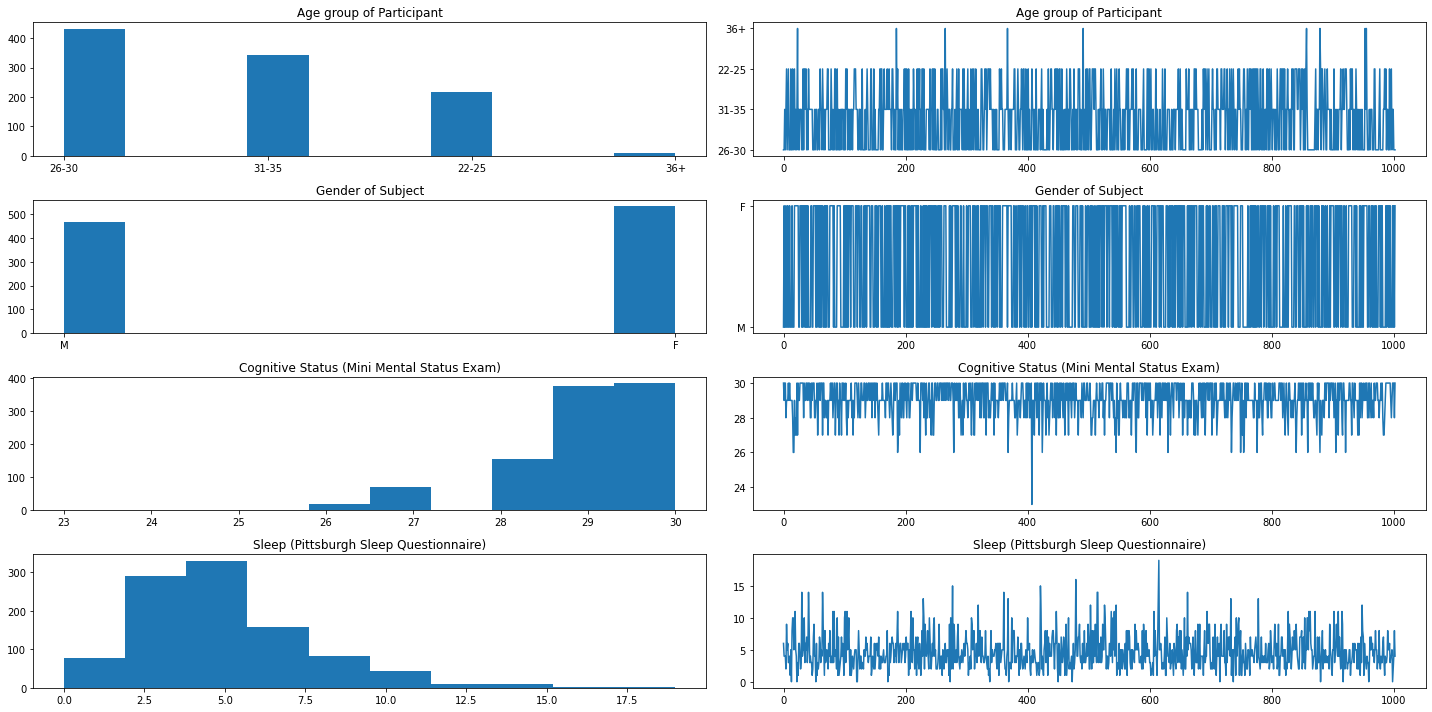

In [7]:
X = netmaps_df.values

y_age = filter_behavioral_df.Age # Age group of Participant, banded in five-year increments
print("y_age shape:", y_age.dropna().shape)
y_gender = filter_behavioral_df.Gender # Gender of Subject
print("y_gender shape:", y_gender.dropna().shape)
y_MMSE_Score = filter_behavioral_df.MMSE_Score # Cognitive Status (Mini Mental Status Exam)
print("y_MMSE_Score shape:", y_MMSE_Score.dropna().shape)
y_PSQI_Score = filter_behavioral_df.PSQI_Score # Sleep (Pittsburgh Sleep Questionnaire)
print("y_PSQI_Score shape:", y_PSQI_Score.dropna().shape)

fig, ax = plt.subplots(4,2,figsize=(20, 10))
ax[0][0].hist(y_age)
ax[0][0].set_title("Age group of Participant")
ax[1][0].hist(y_gender)
ax[1][0].set_title("Gender of Subject")
ax[2][0].hist(y_MMSE_Score)
ax[2][0].set_title("Cognitive Status (Mini Mental Status Exam)")
ax[3][0].hist(y_PSQI_Score)
ax[3][0].set_title("Sleep (Pittsburgh Sleep Questionnaire)")

ax[0][1].plot(y_age)
ax[0][1].set_title("Age group of Participant")
ax[1][1].plot(y_gender)
ax[1][1].set_title("Gender of Subject")
ax[2][1].plot(y_MMSE_Score)
ax[2][1].set_title("Cognitive Status (Mini Mental Status Exam)")
ax[3][1].plot(y_PSQI_Score)
ax[3][1].set_title("Sleep (Pittsburgh Sleep Questionnaire)")

fig.tight_layout()

### Countplots for each of our categorical variables.

/srv/conda/envs/notebook/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/

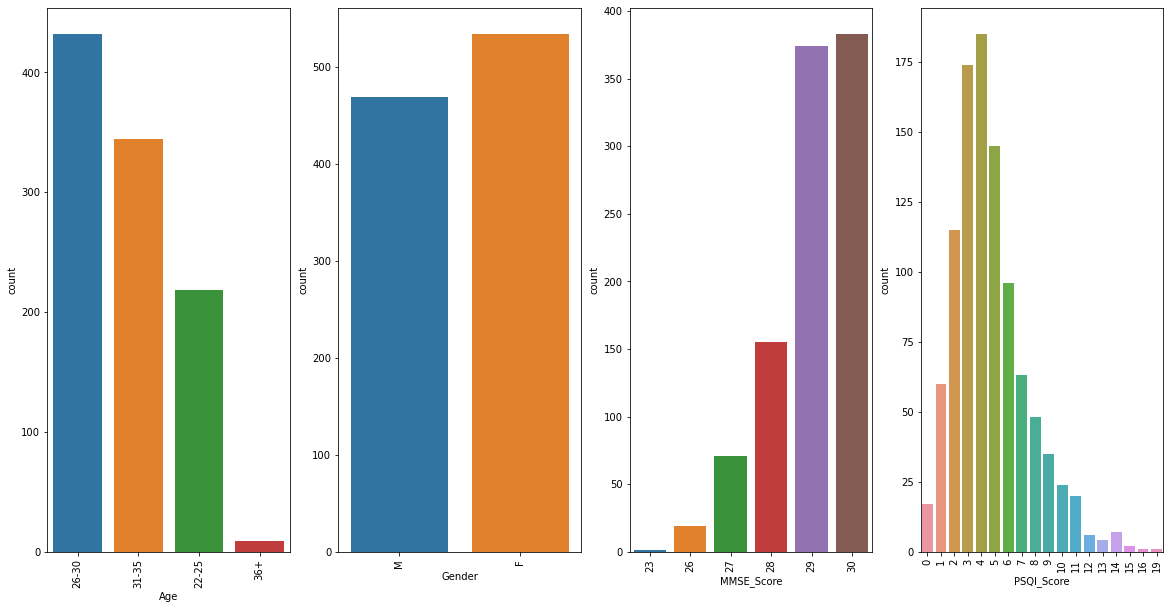

In [8]:
allY = [y_age,y_gender,y_MMSE_Score,y_PSQI_Score]
fig, ax = plt.subplots(1, len(allY), figsize=(20, 10))
for variable, subplot in zip(range(len(allY)), ax.flatten()):
    sns.countplot(allY[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

# What would be the right estimator for our data?

See more [here](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html).

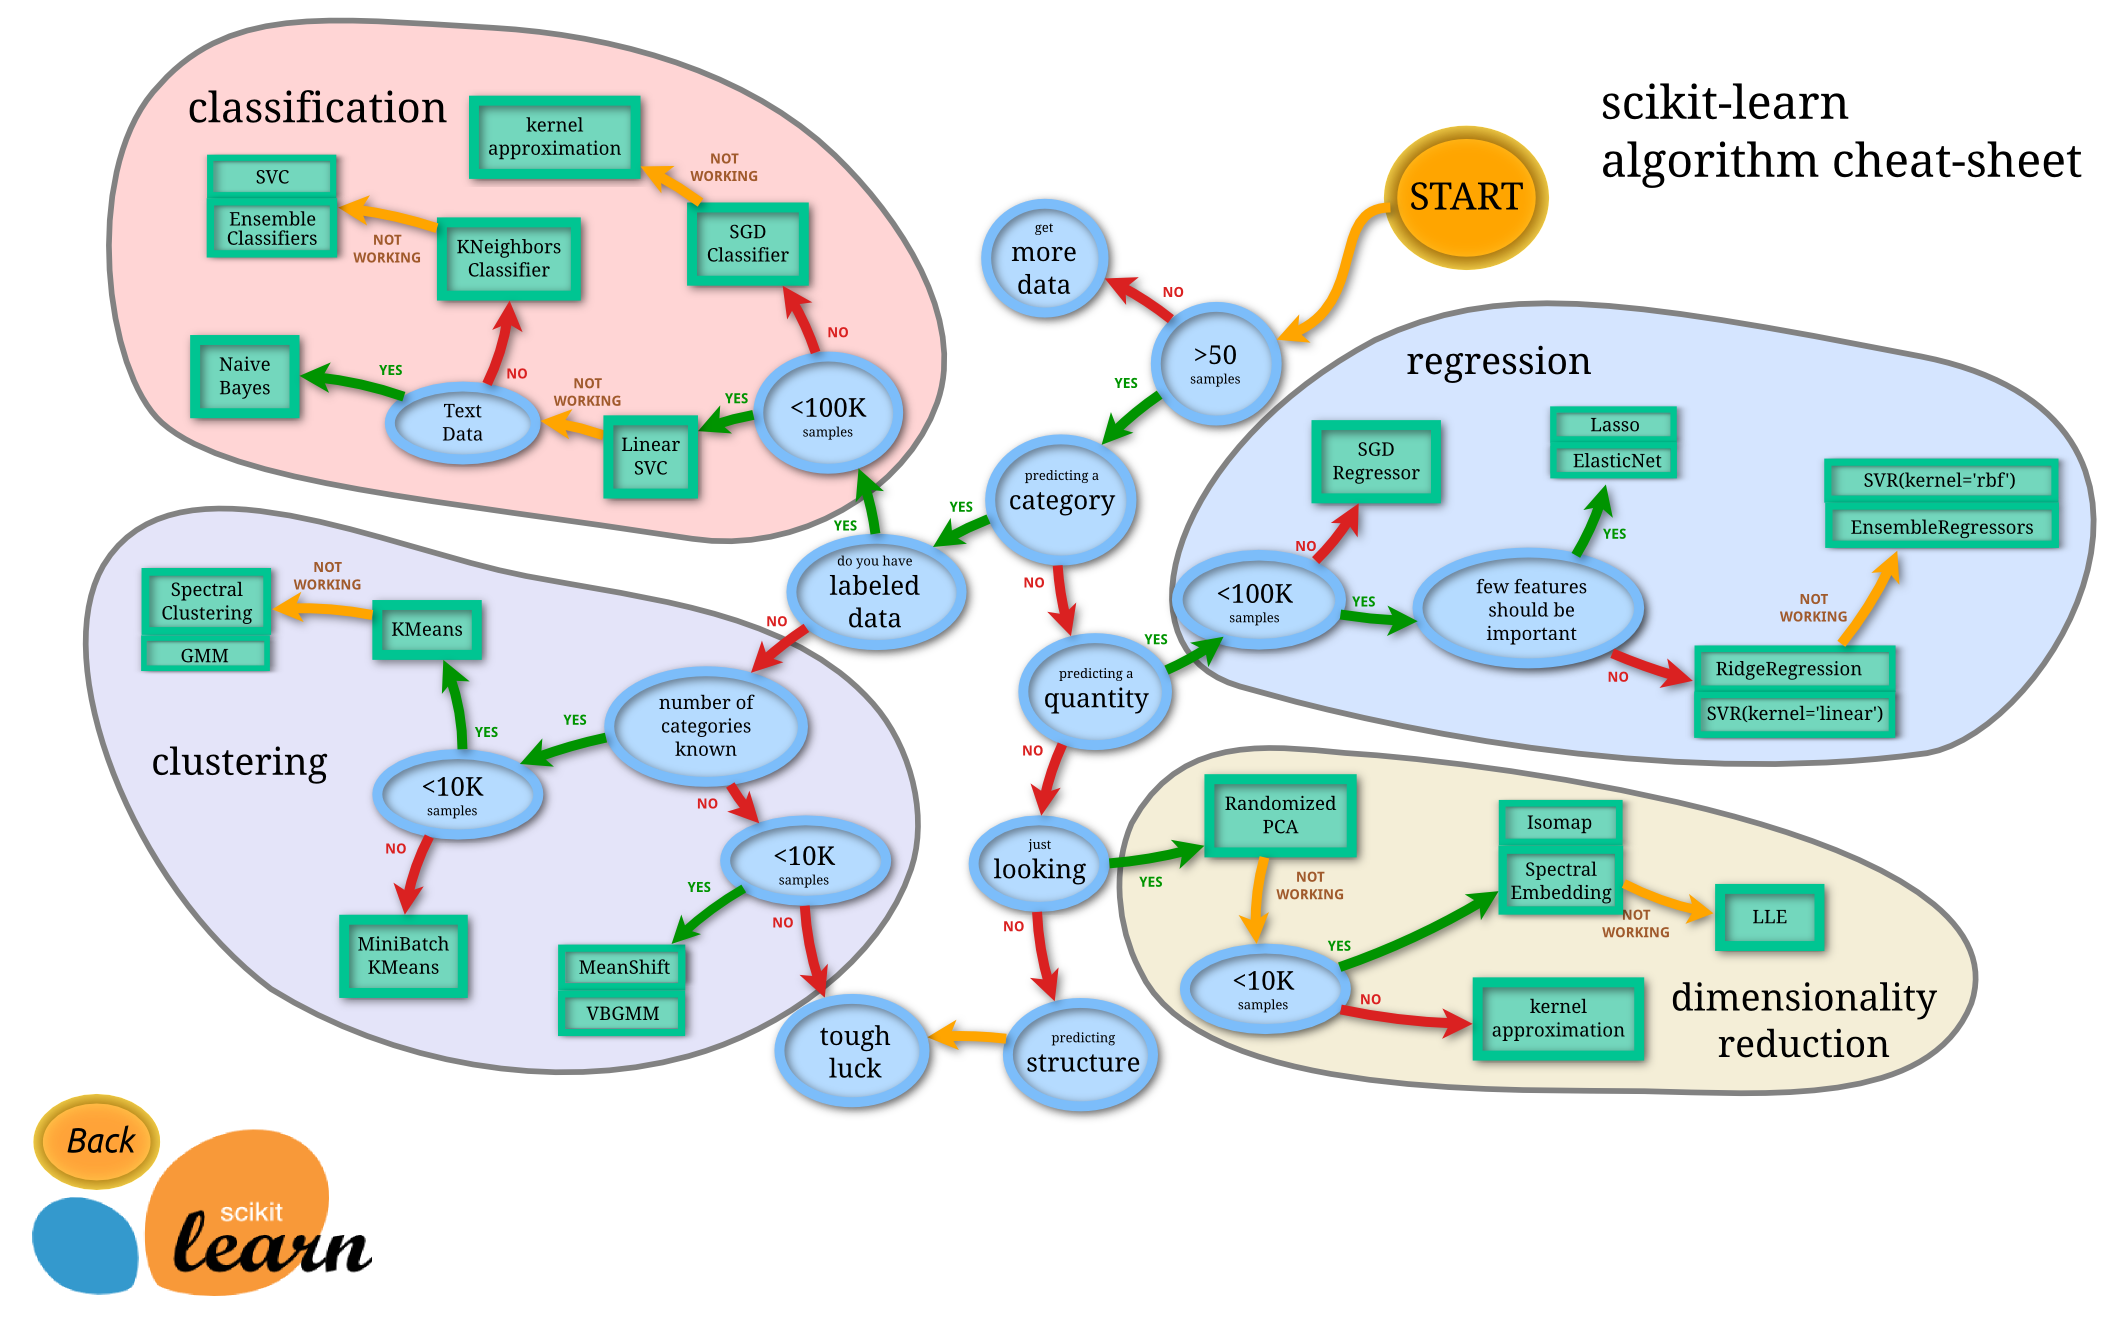

## Classification

### Linear Support Vector Classifier (SVC)

See more [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC).

#### Age group of Participant, banded in five-year increments

Let's try to predict the age group of subjects in our dataset from our network-matrices data.

First we need to split the data into train and test - 

In [9]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y_age, test_size=0.2)

Next, we'll use the LinearSVC, fit the model on train data and check the model accuracy score.

In [10]:
lsvc = make_pipeline(svm.LinearSVC())

In [11]:
lsvc.fit(xtrain, ytrain) # Fit the model according to the given training data.
score = lsvc.score(xtest, ytest) # Return the mean accuracy on the given test data and labels.
print("Test set score: ", score)

Test set score:  0.5422885572139303


In [12]:
cv_scores = cross_val_score(lsvc, xtrain, ytrain, cv=3)
print("CV average score: %.2f" % cv_scores.mean())

CV average score: 0.50


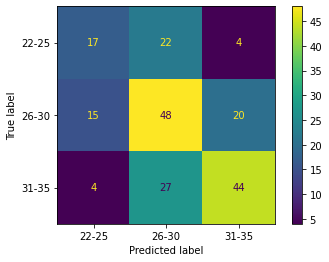

In [13]:
ypred = lsvc.predict(xtest) # Predict class labels for samples in X.
plot_confusion_matrix(lsvc, xtest, ytest) # Plot Confusion Matrix.

<AxesSubplot:>

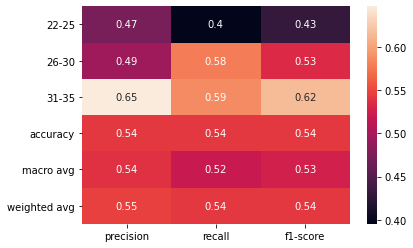

In [14]:
cr = classification_report(ytest, ypred,output_dict=True) # Build a text report showing the main classification metrics.
sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True) # plot scikit-learn classification report

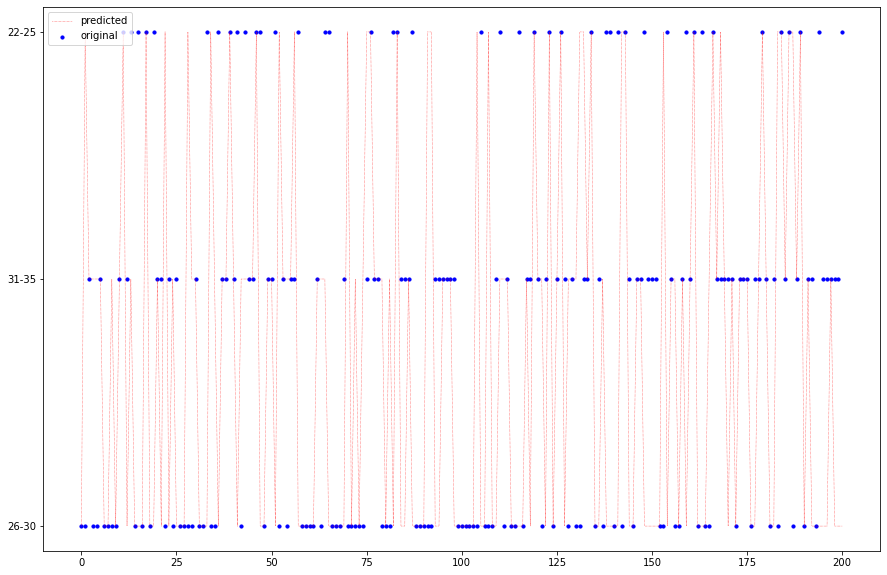

In [15]:
fig, ax = plt.subplots(figsize=(15, 10))
x_ax=range(len(ypred))
ax.scatter(x_ax, ytest, s=10, color="blue", label="original")
ax.plot(x_ax, ypred,':',lw=.5, color="red", label="predicted")
ax.legend()

#### Gender of Subject

We will now repeat the steps above to try to predict the Gender of subjects in our dataset from our network-matrices data.

In [16]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y_gender, test_size=0.2)
lsvc = make_pipeline(svm.LinearSVC())
lsvc.fit(xtrain, ytrain) # Fit the model according to the given training data.
score = lsvc.score(xtest, ytest) # Return the mean accuracy on the given test data and labels.
print("Test set score: ", score)

Test set score:  0.9502487562189055


In [17]:
cv_scores = cross_val_score(lsvc, xtrain, ytrain, cv=3)
print("CV average score: %.2f" % cv_scores.mean())

CV average score: 0.97


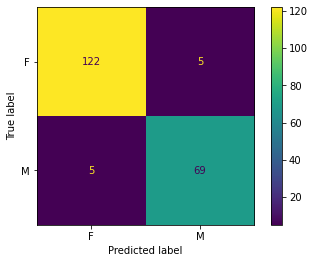

In [18]:
ypred = lsvc.predict(xtest) # Predict class labels for samples in X.
plot_confusion_matrix(lsvc, xtest, ytest) # Plot Confusion Matrix.

<AxesSubplot:>

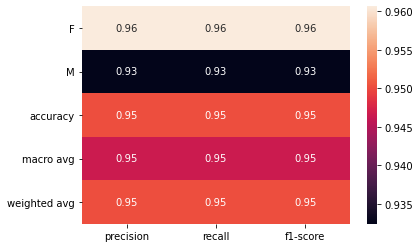

In [19]:
cr = classification_report(ytest, ypred,output_dict=True) # Build a text report showing the main classification metrics.
sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True) # plot scikit-learn classification report

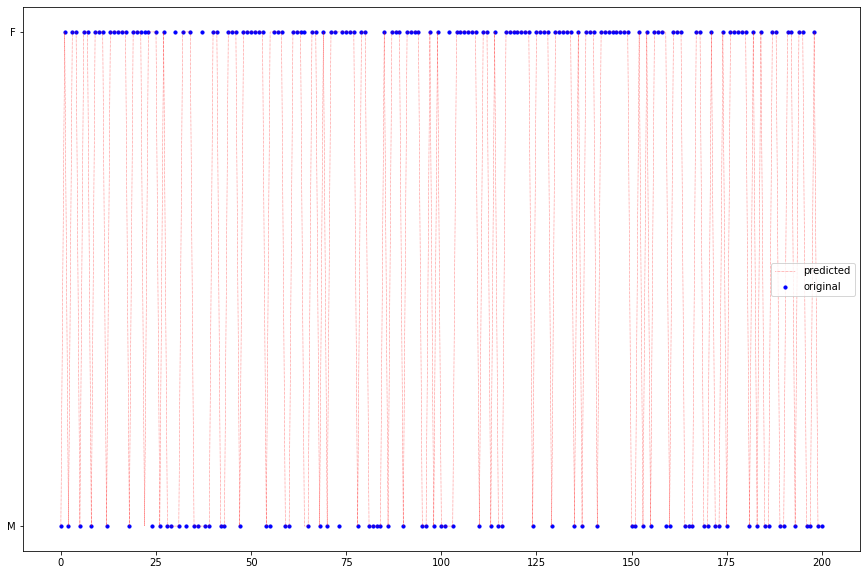

In [20]:
fig, ax = plt.subplots(figsize=(15, 10))
x_ax=range(len(ypred))
ax.scatter(x_ax, ytest, s=10, color="blue", label="original")
ax.plot(x_ax, ypred,':',lw=.5, color="red", label="predicted")
ax.legend()

#### Cognitive Status (Mini Mental Status Exam)

and now again for Cognitive Status (Mini Mental Status Exam)

In [21]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y_MMSE_Score, test_size=0.2)
lsvc = make_pipeline(svm.LinearSVC())
lsvc.fit(xtrain, ytrain) # Fit the model according to the given training data.
score = lsvc.score(xtest, ytest) # Return the mean accuracy on the given test data and labels.
print("Test set score: ", score)

Test set score:  0.32338308457711445


In [22]:
cv_scores = cross_val_score(lsvc, xtrain, ytrain, cv=3)
print("CV average score: %.2f" % cv_scores.mean())

/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"


CV average score: 0.34


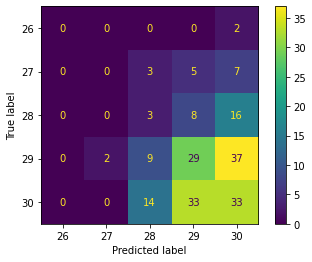

In [23]:
ypred = lsvc.predict(xtest) # Predict class labels for samples in X.
plot_confusion_matrix(lsvc, xtest, ytest) # Plot Confusion Matrix.

/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

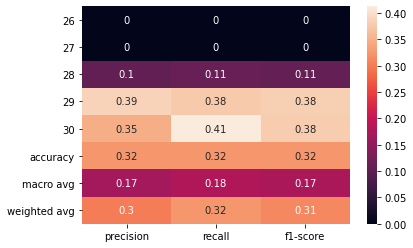

In [24]:
cr = classification_report(ytest, ypred,output_dict=True) # Build a text report showing the main classification metrics.
sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True) # plot scikit-learn classification report

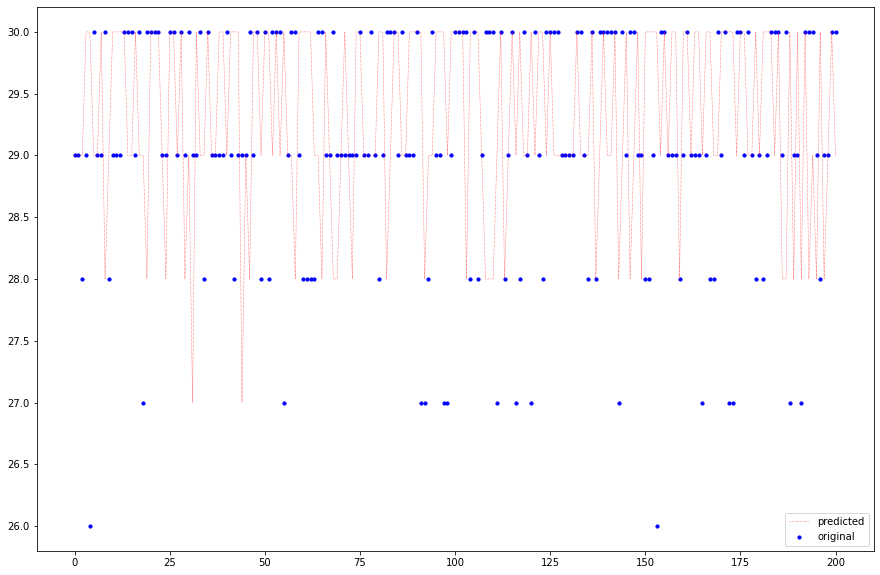

In [25]:
fig, ax = plt.subplots(figsize=(15, 10))
x_ax=range(len(ypred))
ax.scatter(x_ax, ytest, s=10, color="blue", label="original")
ax.plot(x_ax, ypred,':',lw=.5, color="red", label="predicted")
ax.legend()

#### Sleep (Pittsburgh Sleep Questionnaire)

and now again for sleep (Pittsburgh Sleep Questionnaire)

In [26]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y_PSQI_Score, test_size=0.2)
lsvc = make_pipeline(svm.LinearSVC())
lsvc.fit(xtrain, ytrain) # Fit the model according to the given training data.
score = lsvc.score(xtest, ytest) # Return the mean accuracy on the given test data and labels.
print("Test set score: ", score)

Test set score:  0.14925373134328357


In [27]:
cv_scores = cross_val_score(lsvc, xtrain, ytrain, cv=3)
print("CV average score: %.2f" % cv_scores.mean())

/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"


CV average score: 0.14


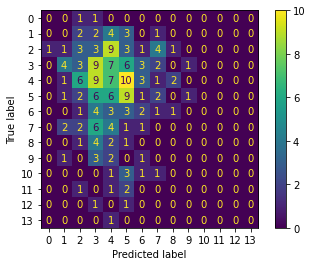

In [28]:
ypred = lsvc.predict(xtest) # Predict class labels for samples in X.
plot_confusion_matrix(lsvc, xtest, ytest) # Plot Confusion Matrix.

/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

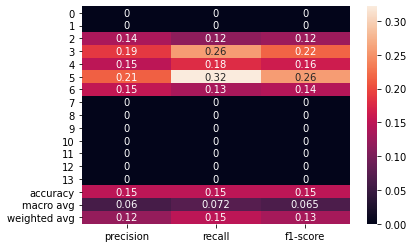

In [29]:
cr = classification_report(ytest, ypred,output_dict=True) # Build a text report showing the main classification metrics.
sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True) # plot scikit-learn classification report

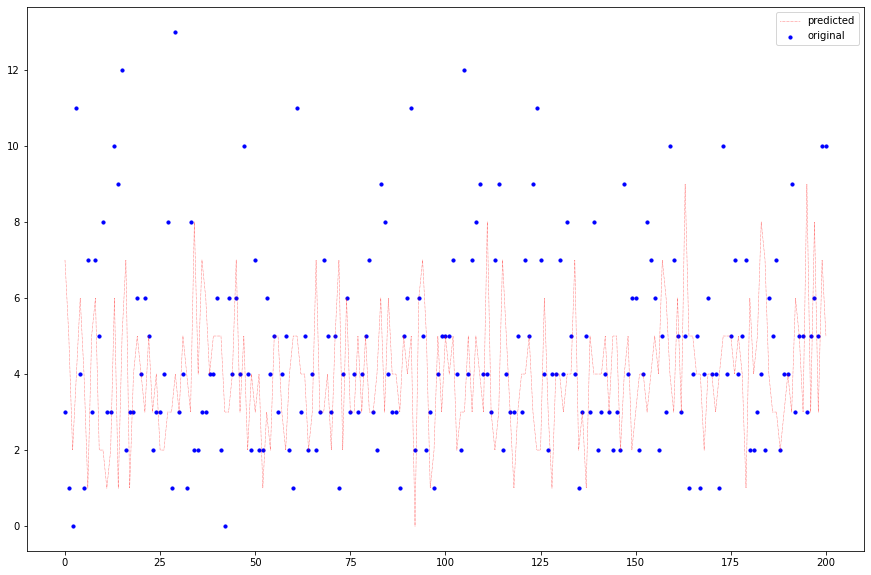

In [30]:
fig, ax = plt.subplots(figsize=(15, 10))
x_ax=range(len(ypred))
ax.scatter(x_ax, ytest, s=10, color="blue", label="original")
ax.plot(x_ax, ypred,':',lw=.5, color="red", label="predicted")
ax.legend()

### Support Vector Classifier (SVC)

See more [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC).

#### Age group of Participant, banded in five-year increments

In [31]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y_age, test_size=0.2)
svc = make_pipeline(svm.SVC())
svc.fit(xtrain, ytrain) # Fit the model according to the given training data.
score = svc.score(xtest, ytest) # Return the mean accuracy on the given test data and labels.
print("Test set score: ", score)

Test set score:  0.5472636815920398


In [32]:
cv_scores = cross_val_score(svc, xtrain, ytrain, cv=3)
print("CV average score: %.2f" % cv_scores.mean())

CV average score: 0.46


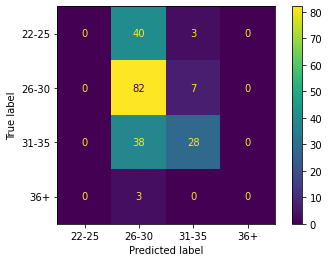

In [33]:
ypred = svc.predict(xtest) # Predict class labels for samples in X.
plot_confusion_matrix(svc, xtest, ytest) # Plot Confusion Matrix.

/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

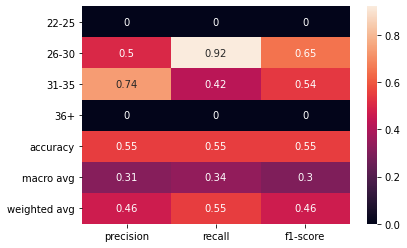

In [34]:
cr = classification_report(ytest, ypred,output_dict=True) # Build a text report showing the main classification metrics.
sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True) # plot scikit-learn classification report

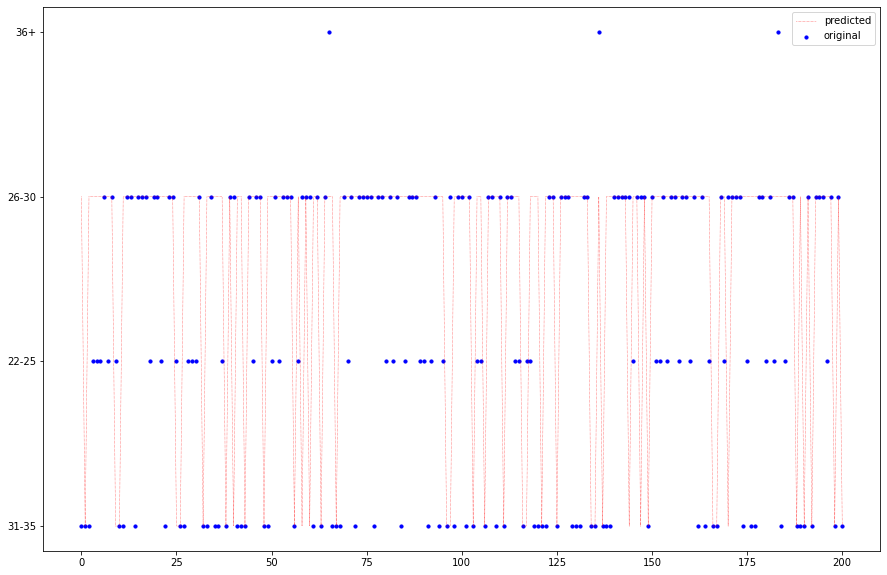

In [35]:
fig, ax = plt.subplots(figsize=(15, 10))
x_ax=range(len(ypred))
ax.scatter(x_ax, ytest, s=10, color="blue", label="original")
ax.plot(x_ax, ypred,':',lw=.5, color="red", label="predicted")
ax.legend()

#### Gender of Subject

In [36]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y_gender, test_size=0.2)
svc = make_pipeline(svm.SVC())
svc.fit(xtrain, ytrain) # Fit the model according to the given training data.
score = svc.score(xtest, ytest) # Return the mean accuracy on the given test data and labels.
print("Test set score: ", score)

Test set score:  0.9601990049751243


In [37]:
cv_scores = cross_val_score(svc, xtrain, ytrain, cv=3)
print("CV average score: %.2f" % cv_scores.mean())

CV average score: 0.94


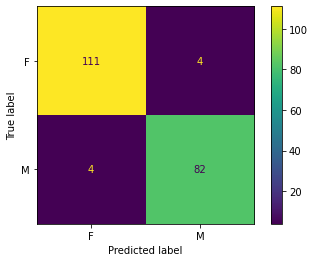

In [38]:
ypred = svc.predict(xtest) # Predict class labels for samples in X.
plot_confusion_matrix(svc, xtest, ytest) # Plot Confusion Matrix.

<AxesSubplot:>

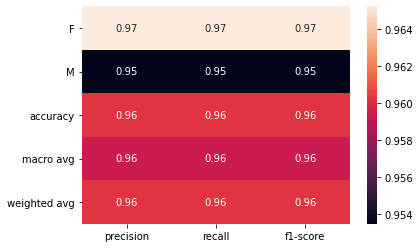

In [39]:
cr = classification_report(ytest, ypred,output_dict=True) # Build a text report showing the main classification metrics.
sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True) # plot scikit-learn classification report

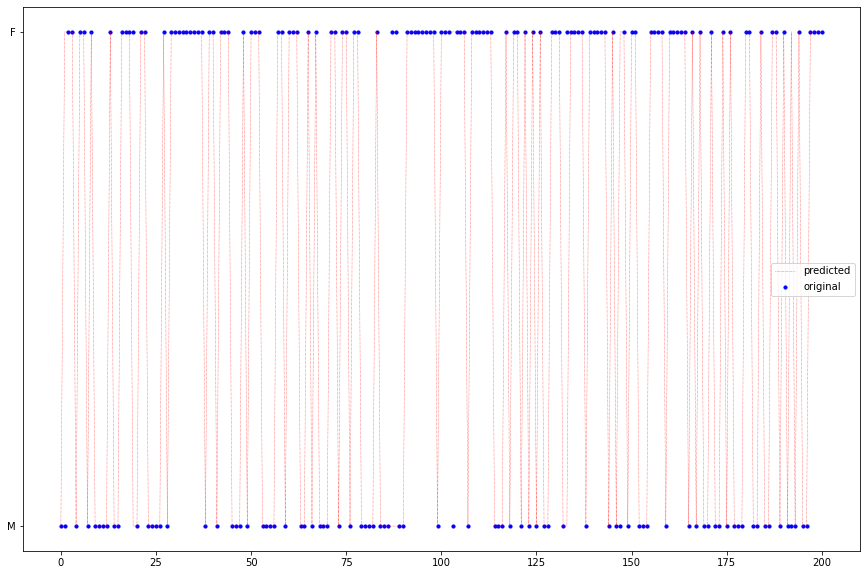

In [40]:
fig, ax = plt.subplots(figsize=(15, 10))
x_ax=range(len(ypred))
ax.scatter(x_ax, ytest, s=10, color="blue", label="original")
ax.plot(x_ax, ypred,':',lw=.5, color="red", label="predicted")
ax.legend()

#### Cognitive Status (Mini Mental Status Exam)

In [41]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y_MMSE_Score, test_size=0.2)
svc = make_pipeline(svm.SVC())
svc.fit(xtrain, ytrain) # Fit the model according to the given training data.
score = svc.score(xtest, ytest) # Return the mean accuracy on the given test data and labels.
print("Test set score: ", score)

Test set score:  0.373134328358209


In [42]:
cv_scores = cross_val_score(svc, xtrain, ytrain, cv=3)
print("CV average score: %.2f" % cv_scores.mean())

/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"


CV average score: 0.40


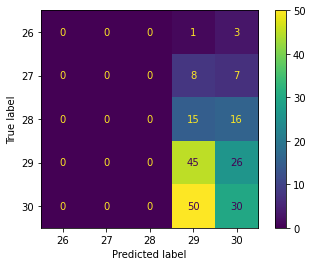

In [43]:
ypred = svc.predict(xtest) # Predict class labels for samples in X.
plot_confusion_matrix(svc, xtest, ytest) # Plot Confusion Matrix.

/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

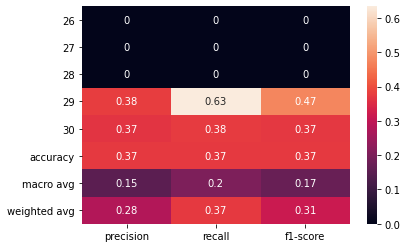

In [44]:
cr = classification_report(ytest, ypred,output_dict=True) # Build a text report showing the main classification metrics.
sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True) # plot scikit-learn classification report

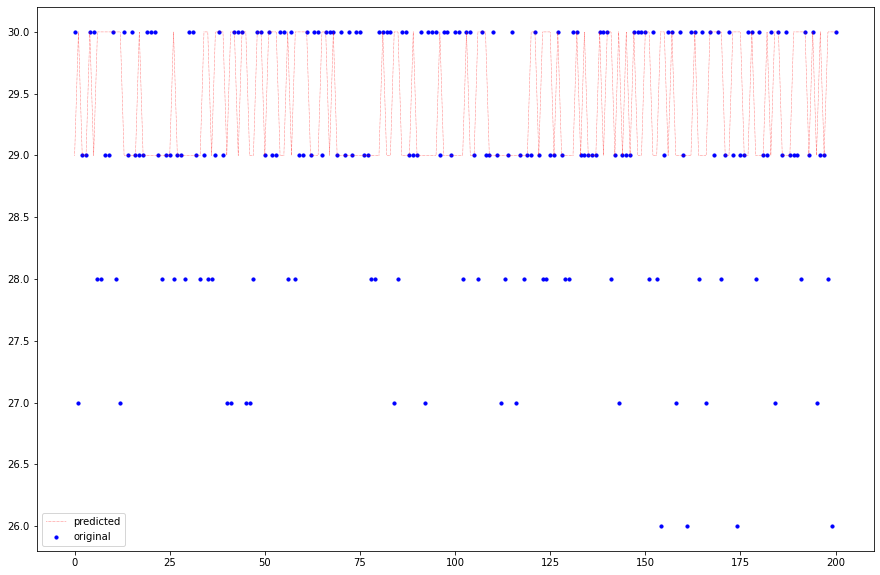

In [45]:
fig, ax = plt.subplots(figsize=(15, 10))
x_ax=range(len(ypred))
ax.scatter(x_ax, ytest, s=10, color="blue", label="original")
ax.plot(x_ax, ypred,':',lw=.5, color="red", label="predicted")
ax.legend()

#### Sleep (Pittsburgh Sleep Questionnaire)

In [46]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y_PSQI_Score, test_size=0.2)
svc = make_pipeline(svm.SVC())
svc.fit(xtrain, ytrain) # Fit the model according to the given training data.
score = svc.score(xtest, ytest) # Return the mean accuracy on the given test data and labels.
print("Test set score: ", score)

Test set score:  0.1791044776119403


In [47]:
cv_scores = cross_val_score(svc, xtrain, ytrain, cv=3)
print("CV average score: %.2f" % cv_scores.mean())

/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"


CV average score: 0.19


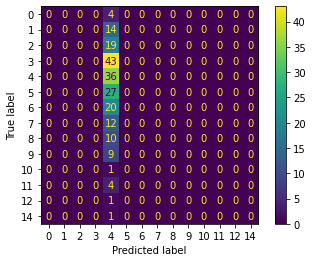

In [48]:
ypred = svc.predict(xtest) # Predict class labels for samples in X.
plot_confusion_matrix(svc, xtest, ytest) # Plot Confusion Matrix.

/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

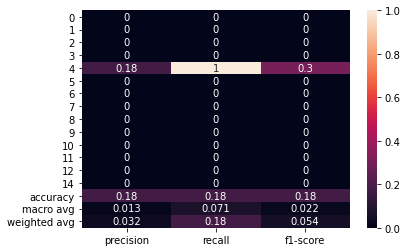

In [49]:
cr = classification_report(ytest, ypred,output_dict=True) # Build a text report showing the main classification metrics.
sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True) # plot scikit-learn classification report

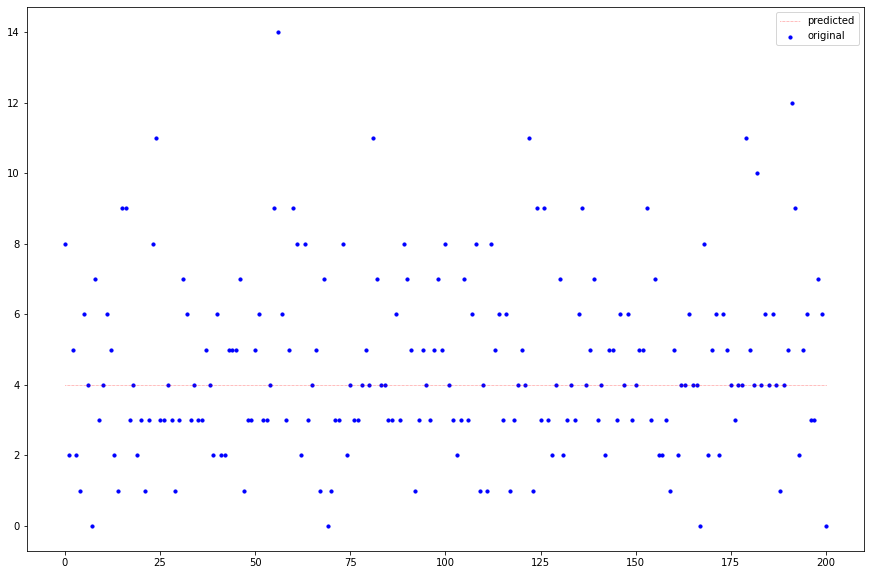

In [50]:
fig, ax = plt.subplots(figsize=(15, 10))
x_ax=range(len(ypred))
ax.scatter(x_ax, ytest, s=10, color="blue", label="original")
ax.plot(x_ax, ypred,':',lw=.5, color="red", label="predicted")
ax.legend()

### KNeighborsClassifier

See more [here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier).

#### Age group of Participant, banded in five-year increments


In [51]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y_age, test_size=0.2)

In [52]:
knc = KNeighborsClassifier(n_neighbors = 4)
knc.fit(xtrain, ytrain)

score = knc.score(xtest, ytest) # Return the mean accuracy on the given test data and labels.
print("Test set score: ", score)

Test set score:  0.42786069651741293


In [53]:
cv_scores = cross_val_score(knc, xtrain, ytrain, cv=3)
print("CV average score: %.2f" % cv_scores.mean())

CV average score: 0.42


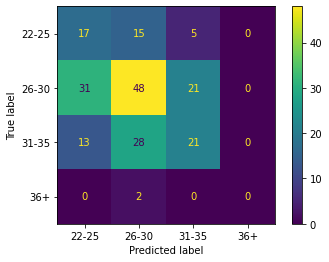

In [54]:
ypred = knc.predict(xtest) # Predict class labels for samples in X.
plot_confusion_matrix(knc, xtest, ytest) # Plot Confusion Matrix.

/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

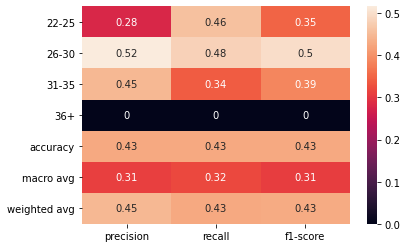

In [55]:
cr = classification_report(ytest, ypred,output_dict=True) # Build a text report showing the main classification metrics.
sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True) # plot scikit-learn classification report

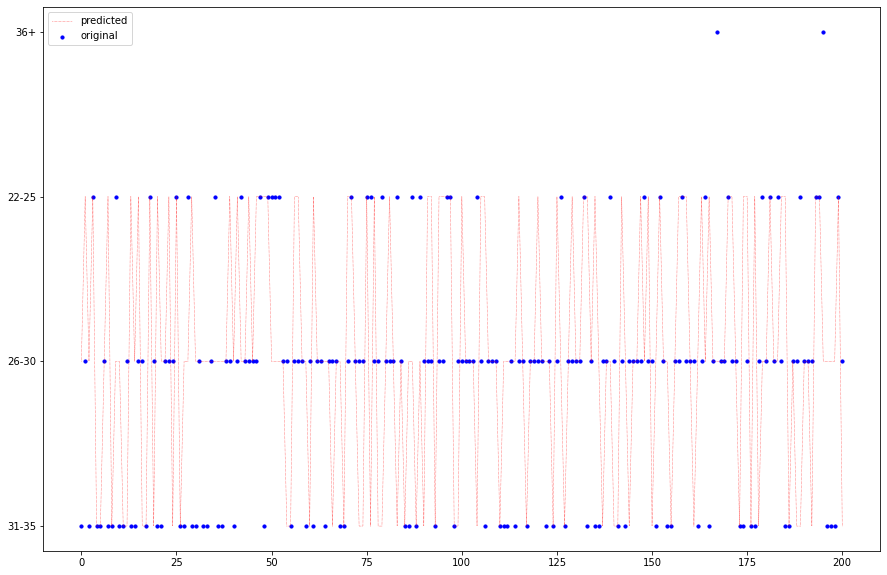

In [56]:
fig, ax = plt.subplots(figsize=(15, 10))
x_ax=range(len(ypred))
ax.scatter(x_ax, ytest, s=10, color="blue", label="original")
ax.plot(x_ax, ypred,':',lw=.5, color="red", label="predicted")
ax.legend()

#### Gender of Subject

In [57]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y_gender, test_size=0.2)

In [58]:
knc = KNeighborsClassifier(n_neighbors = 4)
knc.fit(xtrain, ytrain)

score = knc.score(xtest, ytest) # Return the mean accuracy on the given test data and labels.
print("Test set score: ", score)

Test set score:  0.7512437810945274


In [59]:
cv_scores = cross_val_score(knc, xtrain, ytrain, cv=3)
print("CV average score: %.2f" % cv_scores.mean())

CV average score: 0.73


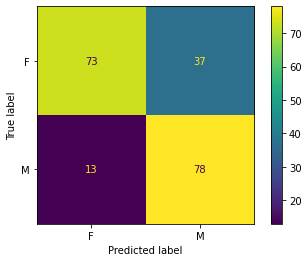

In [60]:
ypred = knc.predict(xtest) # Predict class labels for samples in X.
plot_confusion_matrix(knc, xtest, ytest) # Plot Confusion Matrix.

<AxesSubplot:>

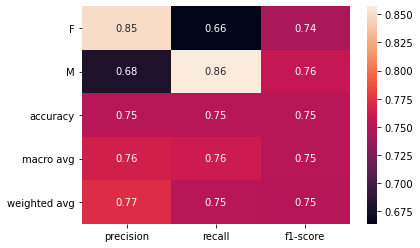

In [61]:
cr = classification_report(ytest, ypred,output_dict=True) # Build a text report showing the main classification metrics.
sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True) # plot scikit-learn classification report

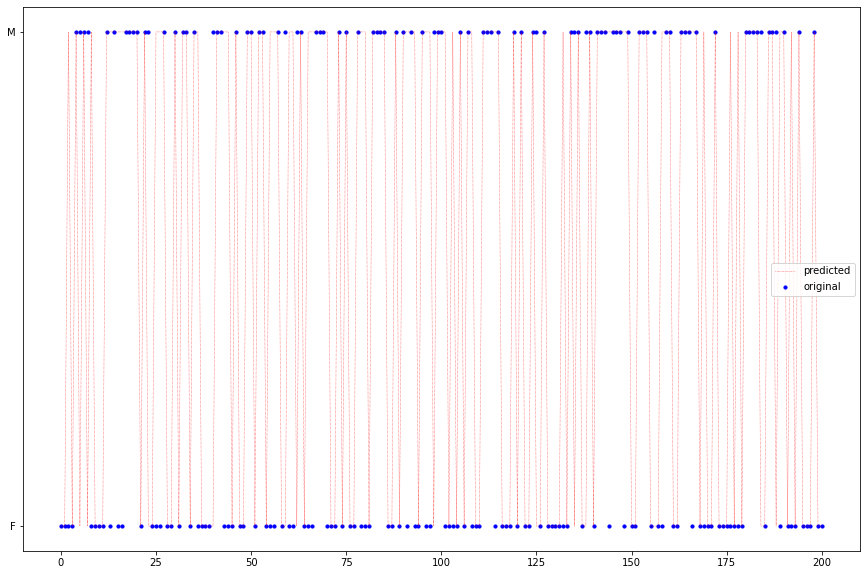

In [62]:
fig, ax = plt.subplots(figsize=(15, 10))
x_ax=range(len(ypred))
ax.scatter(x_ax, ytest, s=10, color="blue", label="original")
ax.plot(x_ax, ypred,':',lw=.5, color="red", label="predicted")
ax.legend()

## Regression

### Regression based on k-nearest neighbors

See more [here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor).

Age group of Participant, banded in five-year increments will not work since catagorical...

#### Cognitive Status (Mini Mental Status Exam)

In [63]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y_MMSE_Score, test_size=0.2)

In [64]:
for n_neighbors in range(2,7):
    print("n_neighbors = ", n_neighbors)
    kng = make_pipeline(KNeighborsRegressor(n_neighbors = n_neighbors))
    kng.fit(xtrain, ytrain)

    score = kng.score(xtest, ytest) # Return the mean accuracy on the given test data and labels.
    print("Test set score: ", score)
    
    cv_scores = cross_val_score(kng, xtest, ytest, cv=3)
    print("CV average score: %.2f" % cv_scores.mean())
    
    ypred = kng.predict(xtest) # Predict class labels for samples in X.
    mse = mean_squared_error(ytest, ypred)
    print("MSE: ", mse)
    print("RMSE: ", mse*(1/2.0)) 
    
    print("\n")

n_neighbors =  2
Test set score:  -0.4808157680477656
CV average score: -0.60
MSE:  1.6206467661691542
RMSE:  0.8103233830845771


n_neighbors =  3
Test set score:  -0.30365327784813956
CV average score: -0.31
MSE:  1.4267551133222776
RMSE:  0.7133775566611388


n_neighbors =  4
Test set score:  -0.2256790528315542
CV average score: -0.31
MSE:  1.3414179104477613
RMSE:  0.6707089552238806


n_neighbors =  5
Test set score:  -0.15301338881852722
CV average score: -0.27
MSE:  1.2618905472636814
RMSE:  0.6309452736318407


n_neighbors =  6
Test set score:  -0.15654401121765882
CV average score: -0.26
MSE:  1.26575456053068
RMSE:  0.63287728026534




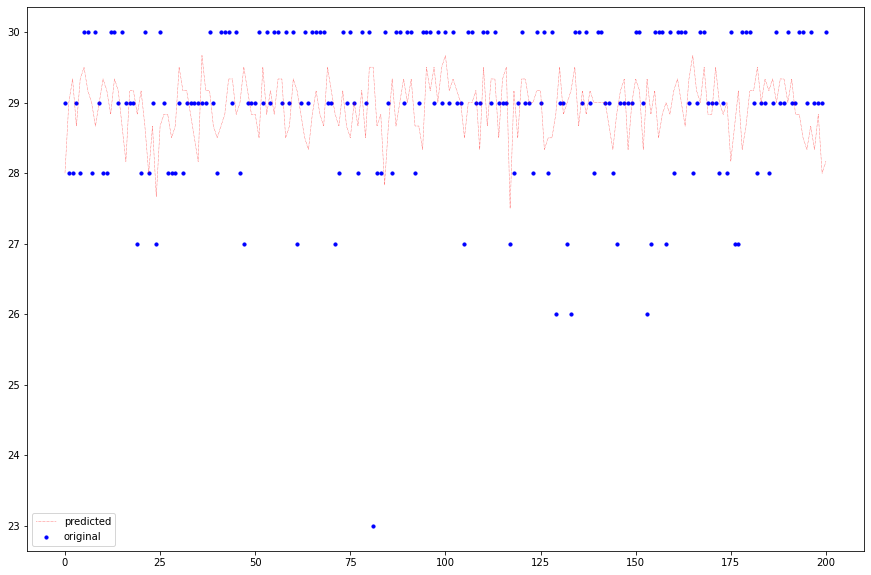

In [65]:
fig, ax = plt.subplots(figsize=(15, 10))
x_ax=range(len(ypred))
ax.scatter(x_ax, ytest, s=10, color="blue", label="original")
ax.plot(x_ax, ypred,':',lw=.5, color="red", label="predicted")
ax.legend()

#### Sleep (Pittsburgh Sleep Questionnaire)

In [66]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y_PSQI_Score, test_size=0.2)

In [67]:
for n_neighbors in range(2,7):
    print("n_neighbors = ", n_neighbors)
    kng = make_pipeline(KNeighborsRegressor(n_neighbors = n_neighbors))
    kng.fit(xtrain, ytrain)

    score = kng.score(xtest, ytest) # Return the mean accuracy on the given test data and labels.
    print("Test set score: ", score)
    
    cv_scores = cross_val_score(kng, xtest, ytest, cv=3)
    print("CV average score: %.2f" % cv_scores.mean())
    
    ypred = kng.predict(xtest) # Predict class labels for samples in X.
    mse = mean_squared_error(ytest, ypred)
    print("MSE: ", mse)
    print("RMSE: ", mse*(1/2.0)) 
    
    print("\n")

n_neighbors =  2
Test set score:  -0.5143641241043382
CV average score: -0.48
MSE:  10.619402985074627
RMSE:  5.309701492537314


n_neighbors =  3
Test set score:  -0.3632863882908004
CV average score: -0.27
MSE:  9.559977888336096
RMSE:  4.779988944168048


n_neighbors =  4
Test set score:  -0.23731601425999793
CV average score: -0.22
MSE:  8.676616915422885
RMSE:  4.338308457711443


n_neighbors =  5
Test set score:  -0.15484719918110912
CV average score: -0.16
MSE:  8.098308457711443
RMSE:  4.049154228855722


n_neighbors =  6
Test set score:  -0.15056357582389146
CV average score: -0.17
MSE:  8.068269762299613
RMSE:  4.034134881149806




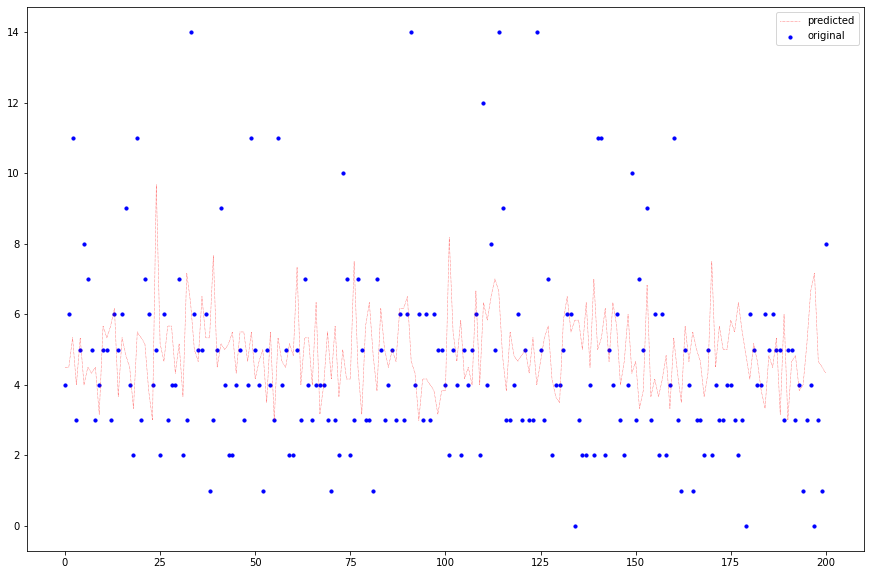

In [68]:
fig, ax = plt.subplots(figsize=(15, 10))
x_ax=range(len(ypred))
ax.scatter(x_ax, ytest, s=10, color="blue", label="original")
ax.plot(x_ax, ypred,':',lw=.5, color="red", label="predicted")
ax.legend()

### Stochastic Gradient Descent (SGD)

See more [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html).

Age group of Participant, banded in five-year increments will not work since catagorical...

#### Cognitive Status (Mini Mental Status Exam)

In [69]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y_MMSE_Score, test_size=0.2)

In [70]:
reg = make_pipeline(SGDRegressor())

In [71]:
reg.fit(xtrain, ytrain) # Fit linear model with Stochastic Gradient Descent.
score = reg.score(xtest, ytest) # Return the coefficient of determination  of the prediction.
print("Test set R-squared:", score)

Test set R-squared: -9.614166936077998e+26


In [ ]:
cv_scores = cross_val_score(reg, xtest, ytest, cv=3)
print("CV average score: %.2f" % cv_scores.mean())

In [ ]:
ypred = reg.predict(xtest) # Predict class labels for samples in X.
mse = mean_squared_error(ytest, ypred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
x_ax=range(len(ypred))
ax.scatter(x_ax, ytest, s=10, color="blue", label="original")
ax.plot(x_ax, ypred,':',lw=.5, color="red", label="predicted")
ax.legend()

#### Sleep (Pittsburgh Sleep Questionnaire)

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y_PSQI_Score, test_size=0.2)

In [ ]:
reg = make_pipeline(SGDRegressor())

In [ ]:
reg.fit(xtrain, ytrain) # Fit linear model with Stochastic Gradient Descent.
score = reg.score(xtest, ytest) # Return the coefficient of determination  of the prediction.
print("Test set R-squared:", score)

In [ ]:
cv_scores = cross_val_score(reg, xtest, ytest, cv=3)
print("CV average score: %.2f" % cv_scores.mean())

In [ ]:
ypred = reg.predict(xtest) # Predict class labels for samples in X.
mse = mean_squared_error(ytest, ypred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
x_ax=range(len(ypred))
ax.scatter(x_ax, ytest, s=10, color="blue", label="original")
ax.plot(x_ax, ypred,':',lw=.5, color="red", label="predicted")
ax.legend()